<h1 style = "color: yellow"> 11785 HW2P2 Face Verification Fall 2024 Slack</h1>

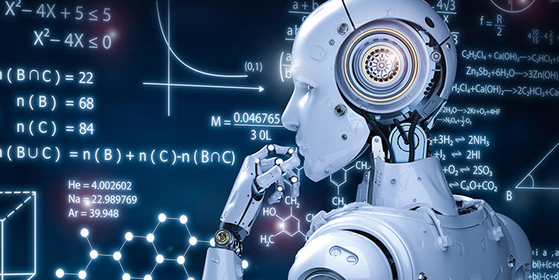

# 1. **Introduction**

<h3 style = "color: orange"> Description </h3>

<p> 
In this homework, you will work on pattern recognition problems that require position invariance. Specifically, you will work on the problem of verifying faces in images. In typical pictures of faces, the face is rarely perfectly centered. Different pictures of the same person may have the face shifted by varying amounts. The classifier must recognize the face regardless of this indeterminacy of position. This calls for position-invariant models, specifically Convolutional Neural Networks, or CNNs.
</p>

<h3 style = "color: orange"> Goal </h3>

<p> Face verification refers to the task of determining whether two face images are of the same person, without necessarily knowing who the person is. Face verification is an instance of a larger class of problems where we attempt to determine if two data instances belong to the same class without necessarily knowing (or having a model for) the class itself.  </p>

# 2. **Imports**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import torch
from facenet_pytorch import InceptionResnetV1
import numpy as np
from torch import nn
from sklearn.metrics import pairwise_distances
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Lambda, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# validation dataframe pairs
val_pairs_df = pd.read_csv('./val_pairs.txt', sep = ' ', header = None)
val_pairs_df.columns = ['image_1', 'image_2', 'label']
val_pairs_df.head()

,image_1,image_2,label
0,jedbHNtR.jpg,Ec9IfrDJ.jpg,0
1,VKzO8Rfj.jpg,55XJ7RBH.jpg,1
2,ENWv1APv.jpg,78v1oFSE.jpg,1
3,P47FsB80.jpg,yRO39XNP.jpg,0
4,M8WjSbE8.jpg,1sreF84q.jpg,1


In [6]:
# test dataframe pairs
test_pairs_df = pd.read_csv('./test_pairs.txt', sep = ' ', header = None)
test_pairs_df.columns = ['image_1', 'image_2']
test_pairs_df.head()

,image_1,image_2
0,jedbHNtR.jpg,Ec9IfrDJ.jpg
1,VKzO8Rfj.jpg,55XJ7RBH.jpg
2,ENWv1APv.jpg,78v1oFSE.jpg
3,P47FsB80.jpg,yRO39XNP.jpg
4,M8WjSbE8.jpg,1sreF84q.jpg


In [7]:
ver_data_path = './ver_data/'
ver_data_path

'./ver_data/'

# 3. **Exploratory Data Analysis (EDA)**

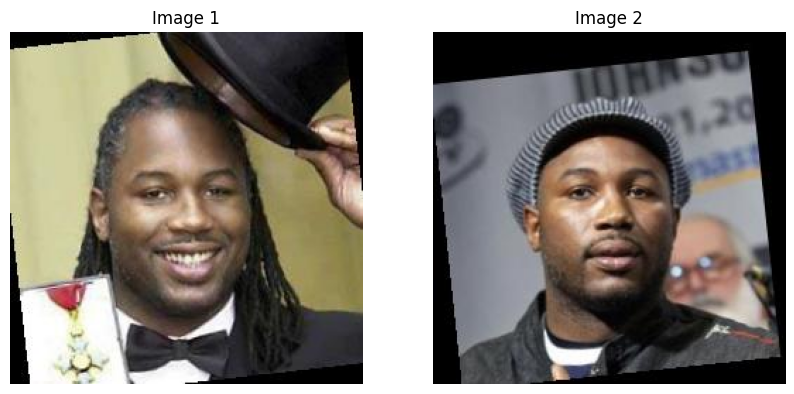

In [8]:
# check similar faces (label 1 - True)
first_image = cv2.imread(ver_data_path + val_pairs_df.iloc[4]['image_1'])
second_image = cv2.imread(ver_data_path + val_pairs_df.iloc[4]['image_2'])

# convert to RGB format
first_image_rgb = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)
second_image_rgb = cv2.cvtColor(second_image, cv2.COLOR_BGR2RGB)

# display the images side by side
plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.imshow(first_image_rgb)
plt.axis('off')
plt.title('Image 1')


plt.subplot(1, 2, 2)
plt.imshow(second_image_rgb)
plt.axis('off')
plt.title('Image 2')  

plt.show()

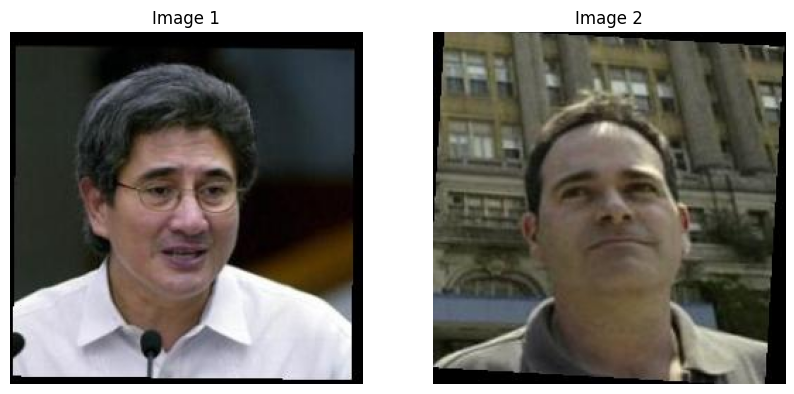

In [9]:
# check NOT similar faces (label 0 - False)
first_image = cv2.imread(ver_data_path + val_pairs_df.iloc[3]['image_1'])
second_image = cv2.imread(ver_data_path + val_pairs_df.iloc[3]['image_2'])

# convert to RGB format
first_image_rgb = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)
second_image_rgb = cv2.cvtColor(second_image, cv2.COLOR_BGR2RGB)

# display the images side by side
plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.imshow(first_image_rgb)
plt.axis('off')
plt.title('Image 1')


plt.subplot(1, 2, 2)
plt.imshow(second_image_rgb)
plt.axis('off')
plt.title('Image 2')  

plt.show()

In [10]:
# shape of images
second_image.shape

(250, 250, 3)

# 4. **Data Preprocessing**

In [11]:
# load and preprocess images
def load_and_preprocess_image(image_name):
    image_path = ver_data_path + image_name
    image = cv2.imread(image_path)
    image = cv2.resize(image, (160, 160)) # resize for model
    image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    normalized_rgb_image = image_RGB / 255.0
    return normalized_rgb_image 

# make a new dataframe, replacing image_names with their numpy array

# train_df
train_df = val_pairs_df[:]
train_df['image_1'] = train_df['image_1'].apply(load_and_preprocess_image)
train_df['image_2'] = train_df['image_2'].apply(load_and_preprocess_image)
train_df.head()

,image_1,image_2,label
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
1,"[[[0.27450980392156865, 0.30980392156862746, 0...","[[[0.00392156862745098, 0.0, 0.0], [0.00392156...",1
2,"[[[0.027450980392156862, 0.0, 0.0], [0.0117647...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",1
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.00784313725490196, 0.0], [0.0, 0.003...",0
4,"[[[0.011764705882352941, 0.0, 0.01568627450980...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",1


In [20]:
# test_df
test_df = test_pairs_df[:]
test_df['image_1'] = test_df['image_1'].apply(load_and_preprocess_image)
test_df['image_2'] = test_df['image_2'].apply(load_and_preprocess_image)
test_df.head()

,image_1,image_2
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,"[[[0.27450982, 0.30980393, 0.29803923], [0.274...","[[[0.003921569, 0.0, 0.0], [0.003921569, 0.0, ..."
2,"[[[0.02745098, 0.0, 0.0], [0.011764706, 0.0, 0...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.007843138, 0.0], [0.0, 0.003921569, ..."
4,"[[[0.011764706, 0.0, 0.015686275], [0.01176470...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [13]:
# convert training values (image_1 and image_2) to tensor shape ((num_samples, 160, 160, 3))
image_1 = np.stack(train_df['image_1'].values) 
image_2 = np.stack(train_df['image_2'].values)  
image_2.shape

(1000, 160, 160, 3)

In [14]:
# save the target variable
y = train_df['label'].values

# 5. **Training, Predicting & Evaluation**

In [16]:
# train

# load Facenet model with pretrained weights, set to evaluation mode
facenet_model = InceptionResnetV1(pretrained='vggface2').eval()

# freeze all layers except the final layers 
for param in facenet_model.parameters():
    param.requires_grad = False

# fine tuning
for param in facenet_model.logits.parameters():
    param.requires_grad = True

# reprocess, convert images to tensors, and get embeddings
def preprocess_and_get_embedding(image_np):
    # Convert numpy image (160x160x3, range [0, 1]) to torch tensor
    image_tensor = torch.from_numpy(image_np.transpose((2, 0, 1))).float()  # convert to (3, 160, 160)
    image_tensor = image_tensor.unsqueeze(0)  # batch dimension to make it (1, 3, 160, 160)

    # pass through Facenet model to get embedding
    with torch.no_grad():
        embedding = facenet_model(image_tensor)
    return embedding.squeeze(0)  # remove batch dimension, making it 1D (512,)

# define a function to compute cosine similarity between embeddings
def cosine_similarity(embedding1, embedding2):
    # ensure embeddings are 1D tensors
    embedding1 = embedding1.view(-1)  
    embedding2 = embedding2.view(-1) 
    return torch.nn.functional.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()


similarities = []
predictions = []

for idx in range(len(image_1)):  # assuming `image_1` and `image_2` contain numpy images
    # get embeddings for each pair
    embedding_1 = preprocess_and_get_embedding(image_1[idx])  # convert image_1[idx] to embedding
    embedding_2 = preprocess_and_get_embedding(image_2[idx])  # convert image_2[idx] to embedding

    # calculate similarity
    similarity = cosine_similarity(embedding_1, embedding_2)
    similarities.append(similarity)

    # set a threshold for classification
    predictions.append(1 if similarity > 0.5 else 0)

# compare predictions with true labels
accuracy = np.mean(np.array(predictions) == y)
print("Accuracy:", accuracy)

Accuracy: 0.906


In [23]:
# predict


submission_data = []

for idx in range(len(test_df)):
    # retrieve preprocessed images directly
    image_1_np = np.array(test_df.iloc[idx]['image_1'])
    image_2_np = np.array(test_df.iloc[idx]['image_2'])

    # get embeddings
    embedding_1 = preprocess_and_get_embedding(image_1_np)
    embedding_2 = preprocess_and_get_embedding(image_2_np)

    # cosine similarity
    similarity = cosine_similarity(embedding_1, embedding_2)

    # the esult with the ID and similarity score
    submission_data.append({'ID': idx, 'Label': similarity})


submission_df = pd.DataFrame(submission_data)

# save to CSV
submission_df.to_csv("submission.csv", index=False)